Based on the

[1]: Option Pricing using Quantum Computers, N. Stamatopoulos et al., 2000, https://arxiv.org/abs/1905.02666

[2]: Qiskit Tutorials, https://qiskit.org/ecosystem/finance/tutorials/03_european_call_option_pricing.html

***

# European call option

As defined in finance, an option is a contract which gives its holder a right but not obligation, to purchase/sell the specified financial asset for a certain strike price during a time period related to some specified date. 

European option is a type of an option, where the possible exhange of the assets must happen at the specified date, but not before. There are two types of an European options, call option for purchasing, and put option for selling. The payoffs for these are defined as

1) Call option: $ \text{max}\{ (S - K),0 \} $
2) Put option: $ \text{max}\{ (K - S),0 \}, $

where $S$ is the spot price of the underlying asset, and $K$ is the strike price.

In this notebook, we calculate the the European Call option, using the the Black-Scholes model. 
The BS-model assumes the underlaying asset price is described by the lognormal distribution, which takes parameters

1) Interest rate: $r$
2) Volatility: $V$
3) Maturity period: $M$
4) Initial asset price: $S_0$

The probability density function of the the spot price can then be written as
$$ P(S) = \frac{1}{S\sigma \sqrt{2\pi}}\exp \bigg[ -\frac{(\ln(S) - \mu)^2}{2\sigma^2} \bigg], $$
where
1) Mean: $\mu = (r - \frac{V^2}{2})T + \ln(S_0)$

2) Standard deviation: $\sigma = V\sqrt{T}$.

Classically, the Black_Scholes equation gives the European call option a price
$$ C = SN(d_{+}) - K e^{-rT} N(d_{-}), $$
where the cumulative normal distribution is 
$$ N(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-z^2/2}dz $$
and the constants
1) $d_+ = \frac{1}{V\sqrt{T}} \big[ \ln(\frac{S_0}{K}) + (r + \frac{V^2}{2})T \big]$

2) $d_- = \frac{1}{V\sqrt{T}} \big[ \ln(\frac{S_0}{K}) - (r + \frac{V^2}{2})T \big]$

Next we will compute the price of the option, first classically, using the Black_Scholes equation, and then using Quantum amplitude estimation.

# Preparing the asset price data

### Imports

In [1]:
!pip install pyarrow   #Pandas dependencies

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from math import erf

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.extensions import UnitaryGate

pi=np.pi

Defaulting to user installation because normal site-packages is not writeable


### Setting the parameters

In [2]:
#For random generated distribution
random_seed_constant = 0
distribution_size = 10000

#The actual financial parameters
initial_price = 10
volatility = 1.5
interest_rate = 0.5
maturity_period = 50 / 365
strike_price = 5

### Generating lognormally distributed price data

In [3]:
def spot_price(N, S, vol, r ,T):
    mu = (r - 0.5*vol**2)*T + np.log(S)
    sigma = vol*np.sqrt(T)
    variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
    np.random.seed(random_seed_constant)
    dist = np.random.lognormal(mu, sigma, size = N)
    return dist

In [4]:
price_data = spot_price(distribution_size, initial_price, volatility, interest_rate, maturity_period)

# Classical algorithm: Black-Scholes model

Here we compute the classical result for the European call option, and save it for later comparison with the quantum result

In [5]:
#Approximation of erf(x)
def gauss_error_function(x):
    value = erf(x)
    return value

#Probability density function for normal distribution
def pdf(x):
    value = np.exp(-x**2/2.0)/(np.sqrt(2*pi))
    return value

#Cumulative probability density function for normal distribution
def cdf(x):
    value = (gauss_error_function(x/np.sqrt(2)) + 1)/2
    return value

In [6]:
def get_d_plus(S, K, vol, r, T):
    value = (np.log(S/K) + (r + 0.5*vol**2)*T)/(vol*np.sqrt(T))
    return value

def get_d_minus(S, K, vol, r, T):
    value = (np.log(S/K) + (r - 0.5*vol**2)*T)/(vol*np.sqrt(T))
    return value

#Call option
def European_call(S, K, vol, r, T):
    d1 = get_d_plus(S, K, vol, r, T)
    d2 = get_d_minus(S, K, vol, r, T)
    price = S*cdf(d1) - K*np.exp(-r*T)*cdf(d2)
    return price

#Put options
def European_put(S, K, vol, r, T):
    d1 = get_d_plus(S, K, vol, r, T)
    d2 = get_d_minus(S, K, vol, r, T)
    price = K*np.exp(-S*T)*cdf(-d2) - S*cdf(-d1)
    return price

In [7]:
classical_result = European_call(initial_price, strike_price, volatility, interest_rate, maturity_period)
print(f"Classical result = {classical_result}")

Classical result = 5.474989509657585


# Quantum algorithm

We implement the Quantum amplitude estimation using the Maximum Likelihood Quantum Amplitude Estimation (MLQAE).

### Choosing backend simulator

Can be run on

1) Noise-free simulators, such as Qiskit Aer.
2) Noisy simulators, for example IQMFakeAdonis with noise profile correspoding to Helmi Quantum computer. (Amount of available qubits limited by the choice of noise profile)
3) On real quantum computer, such as Helmi. Note that this requires access to the quantum computer. (Qubits again limited by the choice of hardware)

Backends used in this notebook are chosen in the cell below.

In [8]:
from qiskit import Aer
from iqm.qiskit_iqm import IQMFakeAdonis, IQMProvider
import os


#UNCOMMENT YOUR CHOICE OF BACKEND
#Noiseless simulator----------------------------------------------
#backend_simulator = Aer.get_backend('aer_simulator_statevector')
#-----------------------------------------------------------------

#Fake simulating Helmi--------------------------------------------
#backend_simulator = IQMFakeAdonis()
#-----------------------------------------------------------------

#Helmi quantum computer (Requires connection)---------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_simulator = provider.get_backend()
#-----------------------------------------------------------------

### Parameters for the quantum algorithm

1) The amount of qubits `m_qbits` used for the encoding of the spot price $S$. Total qubits used will be `2*m_qbits + 1`

2) Number of the different Grover iterations `grover_amount`

3) Number of shots `shot_amount` for each circuit

4) Rescaling parameter `c_rescale`

In [9]:
m_qbits = 2        #Must be larger than 1, uses total of 2*m_qbits+1
grover_amount = 4
shot_amount = 100
c_rescale = 0.25    #Adjust for accuracy

#Exponential or linear Grover scheme
#grover_list = [0] + [2**x for x in range(grover_amount-1)]
grover_list = [0] + [x for x in range(1, grover_amount)]

shot_list = [shot_amount for i in range(len(grover_list))]

### Preparation

For the suitable linear fit to the lognormal distribution, we choose the domain based on the mean and standard deviation. This domain is mapped into the piecewise linear function with image dependent on the the strike price, which also serves as the breakpoint.

In [10]:
def get_domain_and_image(dist, K):
    mean_value = np.mean(dist)
    stddev = np.std(dist)
    confidence = 3
    low = np.maximum(0, mean_value - confidence*stddev)
    high = mean_value + confidence*stddev
    domain = [low, high]
    image = [0, high - K]
    breaks = [low, K]
    return domain, image, breaks

Function for data binning

In [11]:
def binning(dist, m, bin_low, bin_high):
    N_bins = 2**m
    df = pd.DataFrame(dist)
    bins = np.linspace(bin_low, bin_high, N_bins+1, endpoint=True)
    df['bins'] = pd.cut(df[0], bins, right=True, include_lowest=True)
    grouped = pd.cut(df[0], bins=bins).value_counts()
    grouped = df.groupby(pd.cut(df[0], bins=bins, right=True), observed=False).size()
    total = grouped.sum()
    values_normed = []
    for key, value in list(grouped.items()):
        values_normed.append(value/total)
    return bins, values_normed

Helper functions used to visualize the spot proce and the payoff

In [12]:
def linear_map(m, domain, ind):
    a, b = domain
    return a + (b - a)/(2**m - 1)*ind

def get_payoff_function(m, domain, breaks, ind):
    theta_x = linear_map(m, domain, ind)
    value = 0
    offsets = [0,0]
    slopes = [0,1]
    for i in range(len(breaks)):
        if theta_x >= breaks[i]:
            temp = slopes[i]*(theta_x- breaks[1]) + offsets[i]
        else:
            temp = 0
        value += temp
    return value

def get_scaled_payoff(image, f):
    c, d = image
    return (f - c)/(d - c)

Plotting spot price, linear fit, binned data, and payoff function. The payoff is described by the piecewise linear function, with a breakpoint at the strike price.

      Domain = [0.0, 29.4066352932414]
       Image = [0, 24.4066352932414]
 Breakpoints = [0.0, 5]


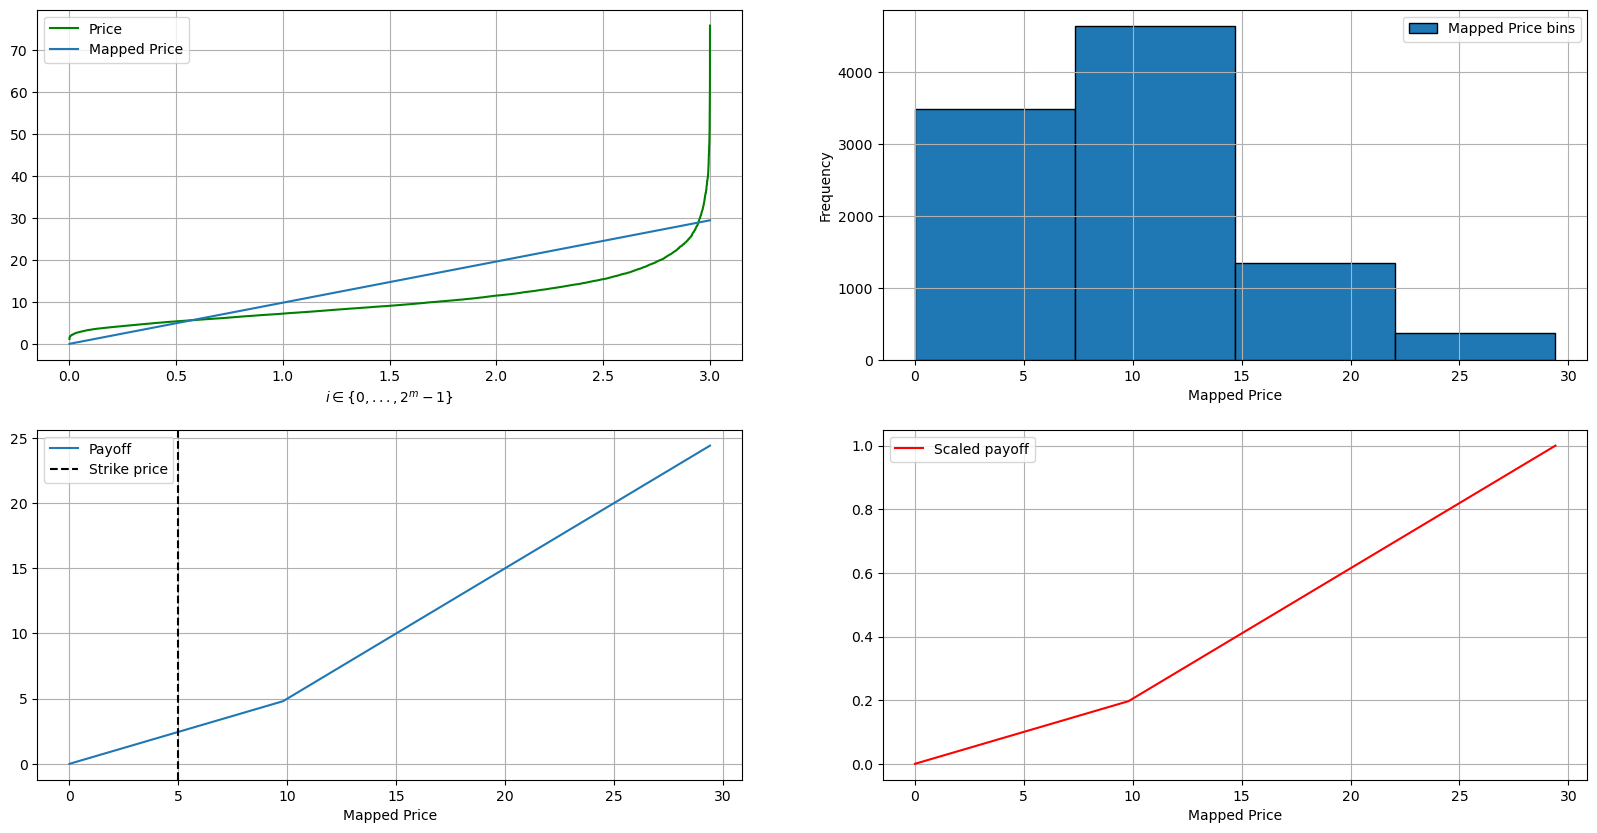

In [13]:
price_domain, price_image, price_breaks = get_domain_and_image(price_data, strike_price)
price_bins, price_probs = binning(price_data, m_qbits, price_domain[0], price_domain[1])
print(f"      Domain = [{price_domain[0]}, {price_domain[1]}]")
print(f"       Image = [{price_image[0]}, {price_image[1]}]")
print(f" Breakpoints = [{price_breaks[0]}, {price_breaks[1]}]")

#print(price_bins)
#print(price_probs)

mapped_price = [linear_map(m_qbits, price_domain, x) for x in range(2**m_qbits)]
payoff = [get_payoff_function(m_qbits, price_domain, [0, strike_price], x) for x in range(2**m_qbits)]
scaled_payoff = [get_scaled_payoff(price_image, f) for f in payoff]

rows = 2
cols = 2
fig, axs = plt.subplots(rows, cols)
fig.set_figwidth(20)
fig.set_figheight(10)

axs[0][0].plot(np.linspace(0, 2**m_qbits-1, len(price_data)), sorted(price_data), color='green', label='Price')
axs[0][0].plot(range(0, 2**m_qbits), mapped_price, color='tab:blue', label='Mapped Price')

axs[0][1].hist(price_data, price_bins, color='tab:blue', label='Mapped Price bins', ec = 'black')

axs[1][0].plot(mapped_price, payoff, color='tab:blue', label='Payoff')
axs[1][0].axvline(strike_price, color='black', linestyle='dashed', label='Strike price')

axs[1][1].plot(mapped_price, scaled_payoff, color='red', label='Scaled payoff')

axs[0][0].set_xlabel('$i \\in \\{0,...,2^m - 1 \\}$')
axs[0][1].set_xlabel('Mapped Price')
axs[1][0].set_xlabel('Mapped Price')
axs[1][0].set_xlabel('Mapped Price')
axs[1][1].set_xlabel('Mapped Price')

axs[0][1].set_ylabel('Frequency')

for i in range(rows):
    for j in range(cols):
        axs[i][j].grid()
        axs[i][j].legend()
plt.show()

### Mapping
Lets denote

1) Domain: $[a,b]$
2) Image: $[c,d]$
3) Breakpoint: $K$

The goal is to design a map according to the call option payoff $ \text{max}\{ (S - K),0 \} $
We first consider linear map
$$ f(i) = \frac{b-a}{2^m - 1}i + a. $$

The slope of the payoff function depends on the comparison of the spot price and the strike price. As a result, we have a piecewise function
$$ f_K(i) = \frac{b - a}{2^m - 1} + a-K \qquad \text{for } f(i) \geqslant K  \text{, and zero otherwise}. $$
The piecewise function is then scaled according to
$$ \tilde{f}_K(i) = \frac{f_K(i) - c}{d - c} \in [0,1]. $$


To define angles $g_0$ and $g_1$ for the Y-rotations, we use the rescaling
$$ \frac{\pi c_r}{2}\tilde{f}_K(i) + \frac{\pi}{4}(1 - c_r) = g_0 + g_1 i.$$

The measured aplitude can then be approximated as
$$ P_1 = \sum_{i}p_i \sin^2(g_0 + g_i i)  \approx  \sum_{i}p_i \bigg[ \frac{\pi c_r}{2}\tilde{f}_K(i) - \frac{\pi c_r}{4} + \frac{1}{2}, \bigg] $$
from which the expected value can be solved

In [14]:
def get_angles(m, domain, image, K, rescaling):
    a, b = domain
    c, d = image
    slopes = np.zeros(2)
    offsets = np.zeros(2)
    g_0 = np.zeros(2)
    g_1 = np.zeros(2)
    #Slopes and offsets for the piecewise function
    offsets[0] = 0
    offsets[1] = K - a
    slopes[0] = 0
    slopes[1] = (b - a)/(2**m - 1)
    #Scaling to [0,1]
    for i in range(len(offsets)):
        offsets[i] = (offsets[i] - c)/(d - c)
        slopes[i] = (slopes[i] - c)/(d - c)
    #Rescaling to get angles
    for i in range(len(offsets)):
        g_0[i] = pi/4*(1-rescaling) - pi/2*rescaling*offsets[i] - i*pi/4*(1-rescaling)
        g_1[i] = pi/2*rescaling*slopes[i]
    #Angles mutiplied by two for the Y-rotation
    return 2*g_0, 2*g_1

g0, g1 = get_angles(m_qbits, price_domain, price_image, strike_price, c_rescale)

### Building gates

First loading the asset price distribution

In [15]:
#Functions for building circuit
def Build_P(m, p_list):
    matrix = np.identity(2**m)
    for i, p in enumerate(p_list):
        matrix[i][0] = np.sqrt(p)
    dist_matrix = np.linalg.qr(matrix)[0]
    dist_gate =  UnitaryGate(dist_matrix, label='  P  ')
    circ = QuantumCircuit(m)
    circ.append(dist_gate, list(range(m)))
    return circ

Comparator circuit for comparing the qubit register to the strike price. The result is encoded into the comparison qubit
$$ |\psi \rangle_n |0\rangle \rightarrow \sum_{i<K}\sqrt{p_i}|i\rangle_n |0\rangle + \sum_{i \geqslant K}\sqrt{p_i}|i\rangle_n |1\rangle $$

In [16]:
def Twos_complement(number, bits):
    if np.floor(np.log2(number)) + 1 > bits:
         raise ValueError(f"Not enough qubits ({bits}) for this choice of integer ({number}) .")
    temp = np.binary_repr(-int(np.ceil(number)), bits)
    value = []
    for i in reversed(range(len(temp))):
        if temp[i]=='1':
            value.append(1)
        else:
            value.append(0)
    return value

def Build_OR():
    circ = QuantumCircuit(3)
    circ.x(range(3))
    circ.ccx(0,1,2)
    circ.x(range(2))
    return circ


def Build_comparator(m, C):
    if np.floor(np.log2(C)) + 1 > m:
        raise ValueError('Not enough qubits for this choice of K.')
    OR = Build_OR().to_gate(label='OR')
    circ = QuantumCircuit(m+m)
    if C <= 0:
        circ.x(m+m)
        return circ
    t = Twos_complement(C, m)
    #Encoding results of comparison into ancilla qubits
    if t[0]==1:
        circ.cx(0, m)
    for i in range(1,m-1):
        if t[i]==0:
            circ.ccx(i, i+m-1, i+m)
        else:
            circ.append(OR, list((i, i+m-1, i+m)))
    #Setting comparison qubit with CNOT-gate
    if t[m-1] == 0:   
        circ.ccx(m-1, m+m-2, m+m-1)
    else:
        circ.append(OR, list((m-1, m+m-2, m+m-1)))
    #Uncomputing ancillas
    for i in reversed(range(1,m-1)):
        if t[i]==0:
            circ.ccx(i, i+m-1, i+m)
        else:
            circ.append(OR, list((i, i+m-1, i+m)))
    if t[0]==1:
        circ.cx(0, m)
    return circ

If the slope of the payoff function is zero, it is enough to apply the rotation $R_y(g_0)$ on the objective qubit.

For nonzero payoff, the rotations are controlled the qubit register holding the price distribution, and by the comparison qubit.

In [17]:
def Build_R(m, controlled, g_0, g_1):
    if controlled == False:
        circ = QuantumCircuit(m+2)
        circ.ry(g_0[0], m+1)
    else:
        temp = QuantumCircuit(m+1)
        circ = QuantumCircuit(m+2)
        temp.ry(g_0[1], m)
        for i in range(m):
            angle = (2**i) * g_1[1]
            temp.cry(angle, i, m)
        controlled_R = temp.to_gate().control()
        target = [m] + list(range(m)) + [m+1]
        circ.append(controlled_R, target)
    return circ

$A$-gate consists of encoding the spot price, performing the comparison of price register and strike price, and applying piecewise rotations. As a whole, the operation represents the mapping
$$ |\psi \rangle_n |0\rangle \rightarrow \sum_{i<K}\sqrt{p_i}|i\rangle_n |0\rangle \big[ \cos(g_0)|0\rangle + \sin(g_0)|1\rangle \big] 
+ \sum_{i \geqslant K}\sqrt{p_i}|i\rangle_n |1\rangle \big[ \cos(g_0 + g(i))|0\rangle + \sin(g_0 + g(i))|1\rangle \big]  $$

In [18]:
def Build_A(m, p_list, g_0, g_1, K):
    P = Build_P(m, p_list)
    R1 = Build_R(m, False, g_0, g_1)
    R2 = Build_R(m, True, g_0, g_1)
    C = Build_comparator(m, K).to_gate(label='  CMP  ')
    C_inv = C.inverse()
    circ = QuantumCircuit(m + m + 1)
    circ.append(P, range(0 ,m))
    circ.append(R1, list(range(0,m)) + list((m+m-1, m+m)))
    circ.append(C, range(0, m+m))
    circ.append(R2, list(range(0,m)) + list((m+m-1, m+m)))
    circ.append(C_inv, range(0, m+m))
    return circ


Reflection operators

In [19]:
def Build_S_0(m):
    circ = QuantumCircuit(m+m+1)
    circ.x(list(range(m)) + list(range(m+m, m+m+1)))
    circ.h(m+m)
    circ.mcx(list(range(0,m)), m+m)
    circ.h(m+m)
    circ.x(list(range(m)) + list(range(m+m, m+m+1)))
    return circ.to_gate(label='  S0  ')

def Build_S_psi0(m):
    circ = QuantumCircuit(m+m+1)
    circ.z(m+m)
    return circ.to_gate(label='  S_psi  ')

Grover operator $Q=AS_0A^{-1}S_{\psi}$

In [20]:
def Build_Q(m, A):
    S_0 = Build_S_0(m)
    S_psi = Build_S_psi0(m)
    A_inv = A.inverse()
    A_inv.label = '  A_inv  '
    circ = QuantumCircuit(m + m + 1)
    circ.append(S_psi, range(m + m + 1))
    circ.barrier()
    circ.append(A_inv, range(m + m + 1))
    circ.barrier()
    circ.append(S_0, range(m + m + 1))
    circ.barrier()
    circ.append(A, range(m + m + 1))
    return circ

### Building circuits and simulator

In [21]:
def Build_circuits(grovers, m, p_list, g_0, g_1, K, domain):
    qcs = []
    a, b = domain
    K = (K-a)/(b-a)*(2**m - 1)
    A = Build_A(m, p_list, g_0, g_1, K).decompose().to_instruction(label='  A  ')
    Q = Build_Q(m, A).to_instruction(label='  Q  ')
    for g in range(len(grovers)):
        req_dist = QuantumRegister(m, 'q')
        req_anc = QuantumRegister(m-1, 'ancilla')
        req_compare = QuantumRegister(1, 'compare')
        req_obj = QuantumRegister(1, 'obj')
        req_classical = ClassicalRegister(1, 'c')
        circ = QuantumCircuit(req_dist, req_anc, req_compare, req_obj, req_classical)
        circ.append(A, range(0, m+m+1))
        circ.barrier()
        for times in range(grovers[g]):
            circ.append(Q, range(0, m+m+1))
        circ.measure(req_obj, req_classical)
        qcs.append(circ)
    return qcs

In [22]:
def simulator(qcs, shots, backend):
    hits = []
    for i in range(len(qcs)):
        job = execute(qcs[i], backend=backend, shots=shots, optimization_level=3, circuit_duration_check=False)
        counts = job.result().get_counts()
        hits.append(counts.get("1",0))
    return hits

### Postprocessing

Performing maximum likelihood estimation

In [23]:
def loglikelihood(theta, g, hits, grovers, shots):
    value = 0.0
    for i in range(g + 1):
        arg = (2*grovers[i] + 1) * theta
        value += hits[i]*np.log(np.sin(arg)**2) + (shots[i] - hits[i])*np.log(np.cos(arg)**2)
        #The factor -1 as we want to maximize the function
    return -1*value

In [24]:
def error_rate(N, grovers, shots, p0):
    Fischer = 0.0
    for i in range(N+1):
        Fischer += shots[i]/(p0*(1 - p0)) * (2*grovers[i] + 1)**2
    error = np.sqrt(1/Fischer)
    return error

In [25]:
def ml_estimation(hits, grovers, shots):
    thetas = []
    #Small parameter to avoid dividing with zero
    epsilon = 10**-15
    #Adjusting affects the search ranges when minimizing he function
    confindence = 1
    range_min = 0.0 + epsilon
    range_max = pi/2 - epsilon
    for g in range(len(grovers)):
        searchRange = (range_min, range_max)
        r = optimize.brute(lambda x: loglikelihood(x, g, hits, grovers, shots), [searchRange], finish=None)
        theta0 = r
        thetas.append(theta0)
        p0 = np.sin(theta0)**2
        p_error = error_rate(g, grovers, shots, p0)
        theta_error = np.arcsin(np.sqrt(p_error))
        range_min = max(theta0 - confindence*theta_error , 0.0 + epsilon)
        range_max = min(theta0 + confindence*theta_error , pi/2 - epsilon)
    return thetas

Expected value from the measured amplitude by reverting the mapping

In [26]:
def Expected(a_tilde, image, rescaling):
    c, d = image
    scaled = (2/(pi*rescaling))*(a_tilde - 0.5 + pi*rescaling/4)
    value = scaled*(d-c) + c
    return value

In [27]:
def Oracle_Calls(N, grovers, shots):
    value = 0
    for i in range(N+1):
        value += shots[i]*(2*grovers[i] + 1)
    return value

### Running the simulation and printing the results

In [28]:
#Building circuits
start = time.time()
qcs = Build_circuits(grover_list, m_qbits, price_probs, g0, g1, strike_price, price_domain)
end = time.time()
print(f"      Building time = {end - start}")

#Simulation
start = time.time()
hitlist = simulator(qcs, shot_amount, backend_simulator)

#Postprocessing
start = time.time()
thetas = ml_estimation(hitlist, grover_list, shot_list)
amps = np.sin(thetas)**2
all_answers = Expected(amps, price_image, c_rescale)

final_answer = all_answers[-1]
end = time.time()
print(f"Postprocessing time = {end - start}")
print()

#Printing results
print(f"     Price qubits: {m_qbits}")
print(f"     Total Qubits: {2*m_qbits + 1}")
print(f"Shots per circuit: {shot_amount}")
print(f"    Grover scheme: {grover_list}")
print()
print(f"           Hits: {hitlist}")
print(f"         Thetas: {thetas}")
print(f"   Amplitudes: : {amps}")
print(f"Expected prices: {all_answers}")
print()
print(f"  Classical result = {classical_result}")
print(f"    Quantum result = {final_answer}")
print(f"        Difference = {final_answer - classical_result}")
print(f"Total Oracle calls = {Oracle_Calls(grover_amount-1, grover_list, shot_list)}")

      Building time = 0.03148484230041504
Postprocessing time = 0.0022325515747070312

     Price qubits: 2
     Total Qubits: 5
Shots per circuit: 100
    Grover scheme: [0, 1, 2, 3]

           Hits: [33, 36, 39, 49]
         Thetas: [0.5787144361875937, 0.7943648935152113, 0.774459594332207, 0.7793043950966531]
   Amplitudes: : [0.29915229 0.50896625 0.4890623  0.49390638]
Expected prices: [-0.27956579 12.7605789  11.52352902 11.82459331]

  Classical result = 5.474989509657585
    Quantum result = 11.824593311585252
        Difference = 6.349603801927667
Total Oracle calls = 1600


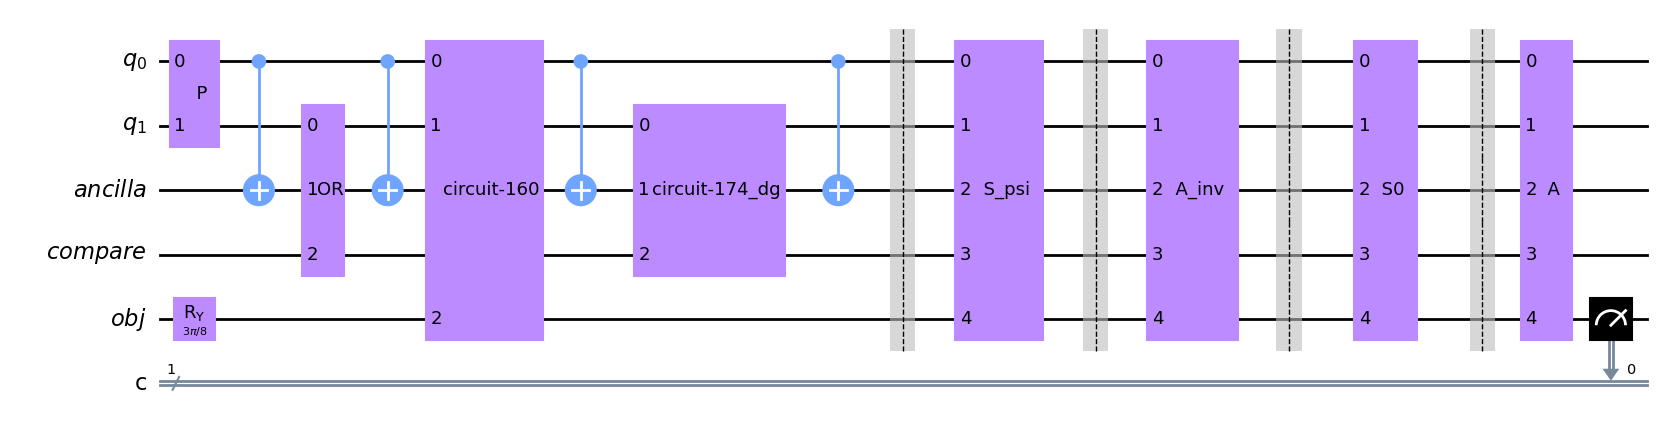

In [29]:
qcs[1].decompose(reps=1).draw('mpl', style="clifford")